In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import roc_curve, auc


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping


from wordcloud import WordCloud

print("✓ Sve biblioteke uspešno učitane!")
print(f"TensorFlow verzija: {tf.__version__}")


✓ Sve biblioteke uspešno učitane!
TensorFlow verzija: 2.20.0


In [ ]:

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
print("✓ NLTK podaci preuzeti!")

✓ NLTK podaci preuzeti!


In [4]:
fake_df = pd.read_csv('data/Fake.csv')
true_df = pd.read_csv('data/True.csv')

fake_df['label'] = 0
true_df['label'] = 1

df = pd.concat([fake_df, true_df], ignore_index=True)

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Ukupan broj vesti: {len(df)}")
print(f"Fake news: {len(fake_df)}")
print(f"True news: {len(true_df)}")
print("\n" + "="*50)
print("\nPrvih 5 redova:")
df.head()

Ukupan broj vesti: 44898
Fake news: 23481
True news: 21417


Prvih 5 redova:


,title,text,subject,date,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",0
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",1
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",1
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",0
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",1


In [ ]:

print("INFORMACIJE O DATASET-U:")
print("="*50)
df.info()

print("\n" + "="*50)
print("STATISTIKA:")
print("="*50)
print(df.describe())

print("\n" + "="*50)
print("PROVERA MISSING VREDNOSTI:")
print("="*50)
print(df.isnull().sum())

INFORMACIJE O DATASET-U:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB

STATISTIKA:
              label
count  44898.000000
mean       0.477015
std        0.499477
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000

PROVERA MISSING VREDNOSTI:
title      0
text       0
subject    0
date       0
label      0
dtype: int64


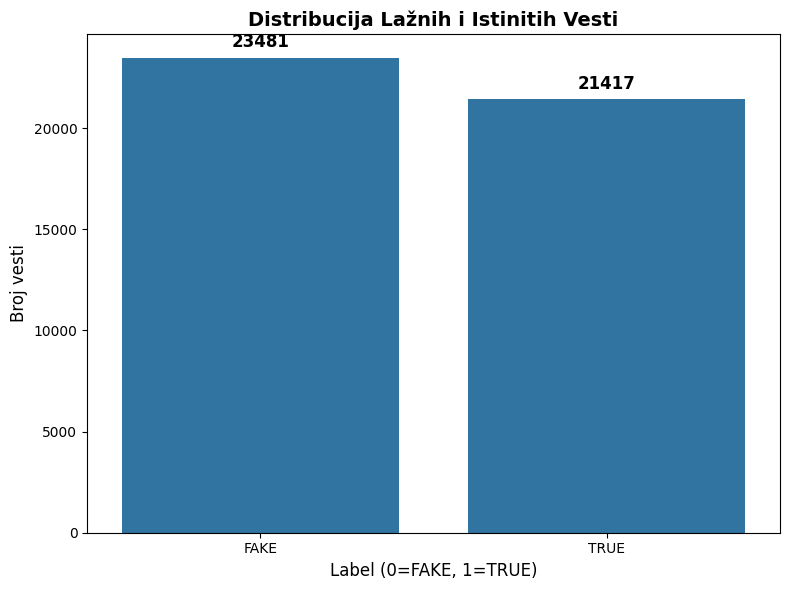

In [ ]:

plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df)
plt.title('Distribucija Lažnih i Istinitih Vesti', fontsize=14, fontweight='bold')
plt.xlabel('Label (0=FAKE, 1=TRUE)', fontsize=12)
plt.ylabel('Broj vesti', fontsize=12)
plt.xticks([0, 1], ['FAKE', 'TRUE'])


for i, v in enumerate(df['label'].value_counts().sort_index().values):
    plt.text(i, v + 500, str(v), ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [7]:
print("Kolone pre brisanja:")
print(df.columns.tolist())
print(f"\nBroj kolona: {len(df.columns)}")

columns_to_drop = ['subject', 'date']

df_clean = df.drop(columns=columns_to_drop)

print("Kolone posle brisanja:")
print(df_clean.columns.tolist())
print(f"nBroj Kolona: {len(df_clean.columns)}")
print("\nPreostale kolone:")
print("- title: naslov vesti")
print("- text: tekst vesti")
print("- label: 0=FAKE, 1=TRUE")


print("PRIMER PODATAKA:")

df_clean.head()

Kolone pre brisanja:
['title', 'text', 'subject', 'date', 'label']

Broj kolona: 5
Kolone posle brisanja:
['title', 'text', 'label']
nBroj Kolona: 3

Preostale kolone:
- title: naslov vesti
- text: tekst vesti
- label: 0=FAKE, 1=TRUE
PRIMER PODATAKA:


,title,text,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",0
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,1
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,1
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",0
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",1


In [8]:

df_clean['full_text'] = df_clean['title'] + ' ' + df_clean['text']

print("✓ Naslov i tekst spojeni u 'full_text' kolonu!")
print("\n" + "="*80)
print("PRIMER FAKE VESTI:")
print("="*80)
fake_idx = df_clean[df_clean['label']==0].index[5]
fake_sample = df_clean.loc[fake_idx, 'full_text']
print(fake_sample[:500] + "...")

print("\n" + "="*80)
print("PRIMER TRUE VESTI:")
print("="*80)
true_idx = df_clean[df_clean['label']==1].index[5]
true_sample = df_clean.loc[true_idx, 'full_text']
print(true_sample[:500] + "...")

✓ Naslov i tekst spojeni u 'full_text' kolonu!

PRIMER FAKE VESTI:
WHERE’S HILLARY? CLINTON SPOTTED Dining Alone  ...

PRIMER TRUE VESTI:
New Jersey's Christie mulls run to lead Republican Party: report WASHINGTON (Reuters) - New Jersey Governor Chris Christie, an early supporter of U.S. President-elect Donald Trump, is considering a run to lead the Republican National Committee, Politico reported on Thursday. Reuters could not immediately confirm the report, and representatives for Christie did not immediately respond to a request for comment.  Christie, whose term as governor ends in January 2018, had been leading Trump’s transi...


In [ ]:
# Funkcija za čišćenje teksta
def clean_text(text):
    """
    Čisti tekst od nepotrebnih karaktera i formatira ga
    """
    
    text = text.lower()
    
    
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    
    text = re.sub(r'\S+@\S+', '', text)
    
    
    text = re.sub(r'@\w+', '', text)
    
  
    text = re.sub(r'#\w+', '', text)
    
    
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()


sample_text = "Check this out! https://example.com @username #news 123 amazing!!!"
print("Original:")
print(sample_text)
print("\nNakon čišćenja:")
print(clean_text(sample_text))

Original:
Check this out! https://example.com @username #news 123 amazing!!!

Nakon čišćenja:
check this out amazing


In [10]:

print("Čišćenje tekstova... (može potrajati 1-2 minuta)")
df_clean['cleaned_text'] = df_clean['full_text'].apply(clean_text)
print("✓ Čišćenje završeno!")


print("\n" + "="*80)
print("PRIMER OČIŠĆENOG TEKSTA:")
print("="*80)
print("ORIGINAL:")
print(df_clean['full_text'].values[0][:300])
print("\nOČIŠĆEN:")
print(df_clean['cleaned_text'].values[0][:300])

Čišćenje tekstova... (može potrajati 1-2 minuta)
✓ Čišćenje završeno!

PRIMER OČIŠĆENOG TEKSTA:
ORIGINAL:
Ben Stein Calls Out 9th Circuit Court: Committed a ‘Coup d’état’ Against the Constitution 21st Century Wire says Ben Stein, reputable professor from, Pepperdine University (also of some Hollywood fame appearing in TV shows and films such as Ferris Bueller s Day Off) made some provocative statements 

OČIŠĆEN:
ben stein calls out th circuit court committed a coup dtat against the constitution st century wire says ben stein reputable professor from pepperdine university also of some hollywood fame appearing in tv shows and films such as ferris bueller s day off made some provocative statements on judge jea


In [11]:

MAX_WORDS = 10000  
MAX_LENGTH = 500   


tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(df_clean['cleaned_text'])


sequences = tokenizer.texts_to_sequences(df_clean['cleaned_text'])


X = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')
y = df_clean['label'].values

print(f"✓ Tokenizacija završena!")
print(f"\nVeličina rečnika: {len(tokenizer.word_index)} reči")
print(f"Koristi se: {MAX_WORDS} najčešćih reči")
print(f"Dužina sekvence: {MAX_LENGTH}")
print(f"\nShape X (features): {X.shape}")
print(f"Shape y (labels): {y.shape}")


print("\n" + "="*80)
print("PRIMER TOKENIZACIJE:")
sample_idx = 0
print(f"\nOriginalni tekst:\n{df_clean['cleaned_text'].values[sample_idx][:200]}...")
print(f"\nTokenizovano (prvih 20 tokena):\n{sequences[sample_idx][:20]}")
print(f"\nNakon padding-a (prvih 20):\n{X[sample_idx][:20]}")
print(f"\nLabel: {y[sample_idx]} ({'FAKE' if y[sample_idx]==0 else 'TRUE'})")

✓ Tokenizacija završena!

Veličina rečnika: 202548 reči
Koristi se: 10000 najčešćih reči
Dužina sekvence: 500

Shape X (features): (44898, 500)
Shape y (labels): (44898,)

PRIMER TOKENIZACIJE:

Originalni tekst:
ben stein calls out th circuit court committed a coup dtat against the constitution st century wire says ben stein reputable professor from pepperdine university also of some hollywood fame appearing ...

Tokenizovano (prvih 20 tokena):
[1715, 3173, 575, 57, 702, 2372, 132, 1075, 5, 1965, 1, 89, 2, 968, 577, 759, 611, 148, 1715, 3173]

Nakon padding-a (prvih 20):
[1715 3173  575   57  702 2372  132 1075    5 1965    1   89    2  968
  577  759  611  148 1715 3173]

Label: 0 (FAKE)


In [12]:
# Podela 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("PODELA PODATAKA:")
print("="*50)
print(f"Training set: {X_train.shape[0]} vesti ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} vesti ({X_test.shape[0]/len(X)*100:.1f}%)")

print("\nDistribucija labela u training setu:")
print(f"FAKE: {np.sum(y_train==0)} ({np.sum(y_train==0)/len(y_train)*100:.1f}%)")
print(f"TRUE: {np.sum(y_train==1)} ({np.sum(y_train==1)/len(y_train)*100:.1f}%)")

print("\nDistribucija labela u test setu:")
print(f"FAKE: {np.sum(y_test==0)} ({np.sum(y_test==0)/len(y_test)*100:.1f}%)")
print(f"TRUE: {np.sum(y_test==1)} ({np.sum(y_test==1)/len(y_test)*100:.1f}%)")

PODELA PODATAKA:
Training set: 35918 vesti (80.0%)
Test set: 8980 vesti (20.0%)

Distribucija labela u training setu:
FAKE: 18785 (52.3%)
TRUE: 17133 (47.7%)

Distribucija labela u test setu:
FAKE: 4696 (52.3%)
TRUE: 4284 (47.7%)


In [ ]:
# Kreiraj model SA POBOLJŠANOM REGULARIZACIJOM
from tensorflow.keras import regularizers

model = Sequential([
    
    Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=MAX_LENGTH),
    
    
    Bidirectional(LSTM(32, return_sequences=True)),  
    Dropout(0.6),  
    
   
    Bidirectional(LSTM(16)), 
    Dropout(0.6),
    
    
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.6),
    
    Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    
    
    Dense(1, activation='sigmoid')
])

# Kompajliranje sa NIŽOM learning rate
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("✓ Model kreiran sa poboljšanom regularizacijom!")
print("\nPROMENE:")
print("- Smanjeni LSTM layeri (64→32, 32→16)")
print("- Povećan Dropout (0.5→0.6)")
print("- Dodata L2 regularizacija")
print("- Smanjena learning rate (0.001→0.0001)")
print("\nARHITEKTURA MODELA:")
print("="*80)
model.summary()

✓ Model kreiran sa poboljšanom regularizacijom!

PROMENE:
- Smanjeni LSTM layeri (64→32, 32→16)
- Povećan Dropout (0.5→0.6)
- Dodata L2 regularizacija
- Smanjena learning rate (0.001→0.0001)

ARHITEKTURA MODELA:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Treniranje sa STROŽIJIM early stopping
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=2, 
    restore_best_weights=True,
    verbose=1
)

# Treniranje
print("Počinje treniranje sa regularizacijom... (može trajati 10-15 minuta)")
print("="*80)

history = model.fit(
    X_train, y_train,
    epochs=15,  
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

print("\n" + "="*80)
print("✓ Treniranje završeno!")

Počinje treniranje sa regularizacijom... (može trajati 10-15 minuta)
Epoch 1/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 173s 368ms/step - accuracy: 0.7651 - loss: 0.9571 - val_accuracy: 0.9926 - val_loss: 0.4958
Epoch 2/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 123s 275ms/step - accuracy: 0.9774 - loss: 0.4813 - val_accuracy: 0.9983 - val_loss: 0.3273
Epoch 3/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 146s 284ms/step - accuracy: 0.9915 - loss: 0.3416 - val_accuracy: 0.9989 - val_loss: 0.2506
Epoch 4/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 124s 277ms/step - accuracy: 0.9952 - loss: 0.2543 - val_accuracy: 0.9950 - val_loss: 0.2038
Epoch 5/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 125s 277ms/step - accuracy: 0.9969 - loss: 0.1925 - val_accuracy: 0.9986 - val_loss: 0.1458
Epoch 6/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 122s 272ms/step - accuracy: 0.9969 - loss: 0.1464 - val_accuracy: 0.9999 - val_loss: 0.1072
Epoch 7/15
449/449 ━━━━━━━━━━━━━━━━━━━━ 120s 268ms/step - accuracy: 0.9980 - loss: 0.1132 - val_accuracy: 0.9993 - val_loss: 0.0833
Epoch 8

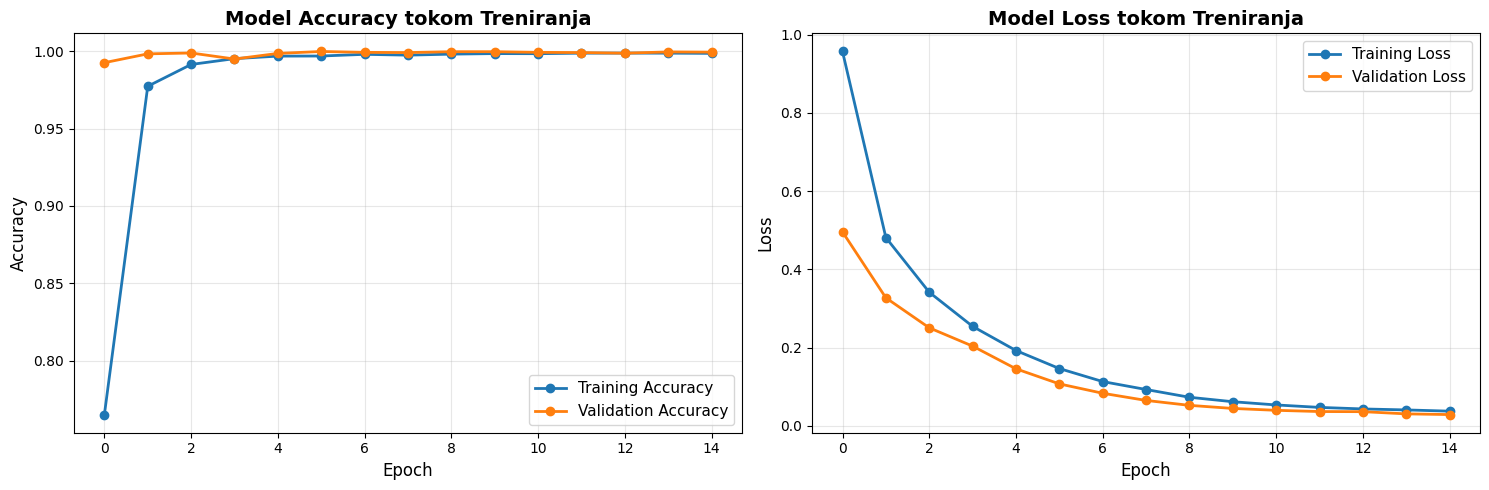

FINALNI REZULTATI TRENIRANJA:
Training Accuracy: 99.86%
Validation Accuracy: 99.94%


In [15]:
# Grafik accuracy i loss tokom treniranja
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, marker='o')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, marker='o')
axes[0].set_title('Model Accuracy tokom Treniranja', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2, marker='o')
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, marker='o')
axes[1].set_title('Model Loss tokom Treniranja', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Prikaži finalne rezultate
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print("FINALNI REZULTATI TRENIRANJA:")
print("="*50)
print(f"Training Accuracy: {final_train_acc*100:.2f}%")
print(f"Validation Accuracy: {final_val_acc*100:.2f}%")

In [16]:
# Predikcije na test setu
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Accuracy
test_accuracy = accuracy_score(y_test, y_pred)

print("EVALUACIJA NA TEST SETU:")
print("="*80)
print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")
print("\n" + "="*80)
print("\nClassification Report:")
print("="*80)
print(classification_report(y_test, y_pred, target_names=['FAKE', 'TRUE']))

281/281 ━━━━━━━━━━━━━━━━━━━━ 21s 72ms/step
EVALUACIJA NA TEST SETU:

Test Accuracy: 99.82%


Classification Report:
              precision    recall  f1-score   support

        FAKE       1.00      1.00      1.00      4696
        TRUE       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



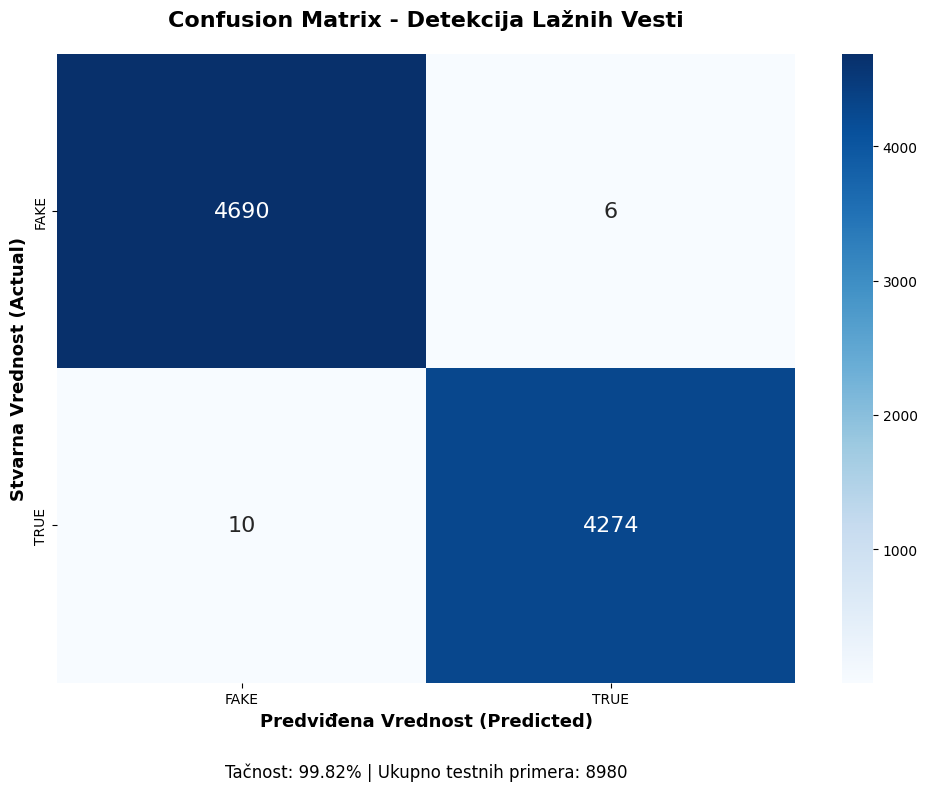


DETALJNA ANALIZA CONFUSION MATRIX:
True Negatives (TN):  4690 - Tačno predviđene FAKE vesti
False Positives (FP): 6 - FAKE vesti pogrešno označene kao TRUE
False Negatives (FN): 10 - TRUE vesti pogrešno označene kao FAKE
True Positives (TP):  4274 - Tačno predviđene TRUE vesti

Precision (FAKE): 99.79%
Precision (TRUE): 99.86%
Recall (FAKE): 99.87%
Recall (TRUE): 99.77%


In [17]:
# Kreiraj confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Vizualizacija
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['FAKE', 'TRUE'],
            yticklabels=['FAKE', 'TRUE'],
            annot_kws={"size": 16})

plt.title('Confusion Matrix - Detekcija Lažnih Vesti', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Stvarna Vrednost (Actual)', fontsize=13, fontweight='bold')
plt.xlabel('Predviđena Vrednost (Predicted)', fontsize=13, fontweight='bold')

# Dodaj objašnjenje
plt.text(0.5, -0.15, 
         f'Tačnost: {test_accuracy*100:.2f}% | '
         f'Ukupno testnih primera: {len(y_test)}',
         ha='center', transform=plt.gca().transAxes, fontsize=12)

plt.tight_layout()
plt.show()

# Detaljno objašnjenje rezultata
tn, fp, fn, tp = cm.ravel()
print("\nDETALJNA ANALIZA CONFUSION MATRIX:")
print("="*80)
print(f"True Negatives (TN):  {tn} - Tačno predviđene FAKE vesti")
print(f"False Positives (FP): {fp} - FAKE vesti pogrešno označene kao TRUE")
print(f"False Negatives (FN): {fn} - TRUE vesti pogrešno označene kao FAKE")
print(f"True Positives (TP):  {tp} - Tačno predviđene TRUE vesti")
print("\n" + "="*80)
print(f"Precision (FAKE): {tn/(tn+fn)*100:.2f}%")
print(f"Precision (TRUE): {tp/(tp+fp)*100:.2f}%")
print(f"Recall (FAKE): {tn/(tn+fp)*100:.2f}%")
print(f"Recall (TRUE): {tp/(tp+fn)*100:.2f}%")

In [ ]:
def predict_news(text, show_confidence=True):
    """
    Predviđa da li je vest lažna ili istinita
    """
    
    cleaned = clean_text(text)
    
    
    sequence = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(sequence, maxlen=MAX_LENGTH, padding='post')
    
    # Predikcija
    prediction = model.predict(padded, verbose=0)[0][0]
    
    # Rezultat
    if prediction > 0.5:
        result = "✅ TRUE NEWS (Istinita vest)"
        confidence = prediction * 100
        color = "\033[92m"  
    else:
        result = "❌ FAKE NEWS (Lažna vest)"
        confidence = (1 - prediction) * 100
        color = "\033[91m" 
    
    reset_color = "\033[0m"
    
    print("="*80)
    print("PREDIKCIJA:")
    print("="*80)
    print(f"{color}{result}{reset_color}")
    if show_confidence:
        print(f"Confidence: {confidence:.2f}%")
        print(f"Raw score: {prediction:.4f} (threshold: 0.5)")
    print("="*80)
    
    return prediction

print("✓ Funkcija za predikciju kreirana!")
print("\nKoristi: predict_news('tvoj tekst vesti ovde')")

✓ Funkcija za predikciju kreirana!

Koristi: predict_news('tvoj tekst vesti ovde')


In [19]:
# Test sa vestima iz test seta
print("TEST NA VESTIMA IZ DATASETA:")
print("\n" + "#"*80)
print("PRIMER 1 - FAKE NEWS:")
print("#"*80)
fake_idx = df_clean[df_clean['label']==0].index[10]
fake_sample = df_clean.loc[fake_idx, 'full_text']
print("\nTekst:")
print(fake_sample[:400] + "...")
print()
predict_news(fake_sample)

print("\n" + "#"*80)
print("PRIMER 2 - TRUE NEWS:")
print("#"*80)
true_idx = df_clean[df_clean['label']==1].index[10]
true_sample = df_clean.loc[true_idx, 'full_text']
print("\nTekst:")
print(true_sample[:400] + "...")
print()
predict_news(true_sample)

TEST NA VESTIMA IZ DATASETA:

################################################################################
PRIMER 1 - FAKE NEWS:
################################################################################

Tekst:
 This New Poll Is TERRIFIC News For Democrats, Really BAD NEWS For Trump While Democratic and Republicans candidates continue to battle it out for who will win their respective nominations, new polling has suggested some very likely outcomes. It looks as though if Donald Trump is the Republican nominee, not only will it tear the GOP into shreds, but they also won t stand a chance of winning the ge...

PREDIKCIJA:
❌ FAKE NEWS (Lažna vest)
Confidence: 99.88%
Raw score: 0.0012 (threshold: 0.5)

################################################################################
PRIMER 2 - TRUE NEWS:
################################################################################

Tekst:
Trump, tech tycoons talk overhaul of H1B visas  NEW YORK/SAN FRANCISCO (Reuters) - Presid

np.float32(0.011387594)

In [20]:
# Test vest sa interneta
news_from_internet = """
Japan's ruling party, led by Prime Minister Sanae Takaichi, is set to seal a decisive win in Sunday's snap election, exit polls suggest.
The country's first female prime minister is seeking a clear public mandate just four months after becoming Liberal Democrat Party (LDP) leader.
Her predicted success is in marked contrast to her two predecessors, under whom the party lost its parliamentary majority because of corruption scandals and rising costs.
An LDP-led coalition has governed Japan for much of its post-war history due to the lack of a strong opposition.
"""

print("TESTIRANJE NA VESTI SA INTERNETA:")
print("="*80)
print("TEKST VESTI:")
print(news_from_internet)
print()

predict_news(news_from_internet)

TESTIRANJE NA VESTI SA INTERNETA:
TEKST VESTI:

Japan's ruling party, led by Prime Minister Sanae Takaichi, is set to seal a decisive win in Sunday's snap election, exit polls suggest.
The country's first female prime minister is seeking a clear public mandate just four months after becoming Liberal Democrat Party (LDP) leader.
Her predicted success is in marked contrast to her two predecessors, under whom the party lost its parliamentary majority because of corruption scandals and rising costs.
An LDP-led coalition has governed Japan for much of its post-war history due to the lack of a strong opposition.


PREDIKCIJA:
✅ TRUE NEWS (Istinita vest)
Confidence: 99.70%
Raw score: 0.9970 (threshold: 0.5)


np.float32(0.99702936)

In [ ]:
# FINALNO - Sačuvaj model i ostale fajlove
print("Čuvam model i potrebne fajlove...")


model.save('fake_news_detector_model.keras')
print("✓ Model sačuvan kao 'fake_news_detector_model.keras'")


import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print("✓ Tokenizer sačuvan!")


config = {
    'MAX_WORDS': MAX_WORDS,
    'MAX_LENGTH': MAX_LENGTH
}
with open('config.pkl', 'wb') as f:
    pickle.dump(config, f)
print("✓ Config sačuvan!")

print("\n" + "="*80)
print("SVE SPREMNO ZA WEB APLIKACIJU!")
print("="*80)

Čuvam model i potrebne fajlove...
✓ Model sačuvan kao 'fake_news_detector_model.keras'
✓ Tokenizer sačuvan!
✓ Config sačuvan!

SVE SPREMNO ZA WEB APLIKACIJU!


In [ ]:
# Provera da li su fajlovi sačuvani
import os

print("PROVERA FAJLOVA:")
print("="*80)

files_to_check = [
    'fake_news_detector_model.keras',
    'tokenizer.pkl',
    'config.pkl'
]

for file in files_to_check:
    if os.path.exists(file):
        size = os.path.getsize(file) / (1024*1024) 
        print(f"✓ {file} - {size:.2f} MB")
    else:
        print(f"✗ {file} - NE POSTOJI!")

print("="*80)

PROVERA FAJLOVA:
✓ fake_news_detector_model.keras - 15.33 MB
✓ tokenizer.pkl - 9.09 MB
✓ config.pkl - 0.00 MB


In [ ]:
# TEST NOVOG MODELA SA REGULARIZACIJOM
from tensorflow import keras
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re

# Funkcija za čišćenje
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

print("TEST MODELA SA REGULARIZACIJOM:")
print("="*80)


fake_text = """Scientists discover that drinking coffee cures all types of cancer! 
This amazing breakthrough is being hidden by big pharma because they 
don't want you to know the truth!"""

fake_clean = clean_text(fake_text)
fake_seq = tokenizer.texts_to_sequences([fake_clean])
fake_pad = pad_sequences(fake_seq, maxlen=MAX_LENGTH, padding='post')
fake_pred = model.predict(fake_pad, verbose=0)[0][0]

print("TEST 1 - FAKE VEST:")
print(f"Score: {fake_pred:.6f}")
print(f"Rezultat: {'✅ FAKE' if fake_pred < 0.5 else '❌ TRUE (GREŠKA!)'}")
print(f"Očekivano: < 0.5 (FAKE)")

print("\n" + "="*80)


true_text = """The Federal Reserve announced Wednesday that it will maintain interest 
rates at current levels, citing concerns about inflation and economic 
uncertainty. The decision was widely expected by economists and market analysts."""

true_clean = clean_text(true_text)
true_seq = tokenizer.texts_to_sequences([true_clean])
true_pad = pad_sequences(true_seq, maxlen=MAX_LENGTH, padding='post')
true_pred = model.predict(true_pad, verbose=0)[0][0]

print("TEST 2 - TRUE VEST:")
print(f"Score: {true_pred:.6f}")
print(f"Rezultat: {'✅ TRUE' if true_pred > 0.5 else '❌ FAKE (GREŠKA!)'}")
print(f"Očekivano: > 0.5 (TRUE)")

print("\n" + "="*80)


print("TEST 3 - Na test setu:")
y_pred_test = model.predict(X_test[:100], verbose=0)
y_pred_binary = (y_pred_test > 0.5).astype(int).flatten()
y_actual = y_test[:100]

correct = np.sum(y_pred_binary == y_actual)
print(f"Tačnost na 100 primera: {correct}/100 = {correct}%")

print("\n" + "="*80)

if fake_pred < 0.5 and true_pred > 0.5:
    print("🎉🎉🎉 MODEL RADI SAVRŠENO! 🎉🎉🎉")
    print("Možeš pokrenuti web app!")
elif fake_pred < 0.5 and true_pred < 0.5:
    print("⚠️ Model i dalje ima bias prema FAKE")
    print(f"TRUE score: {true_pred:.6f} - blizu 0.5 ali ne prelazi")
else:
    print("⚠️ Model i dalje ima problema")

TEST MODELA SA REGULARIZACIJOM:
TEST 1 - FAKE VEST:
Score: 0.001286
Rezultat: ✅ FAKE
Očekivano: < 0.5 (FAKE)

TEST 2 - TRUE VEST:
Score: 0.002291
Rezultat: ❌ FAKE (GREŠKA!)
Očekivano: > 0.5 (TRUE)

TEST 3 - Na test setu:
Tačnost na 100 primera: 100/100 = 100%

⚠️ Model i dalje ima bias prema FAKE
TRUE score: 0.002291 - blizu 0.5 ali ne prelazi


In [ ]:
# TEST SA VESTIMA SLIČNIJIM DATASETU
print("TEST SA RAZLIČITIM VESTIMA:")
print("="*80)


political_true = """
Washington - President announced today a new policy regarding immigration reform. 
The White House press secretary confirmed the decision during a regular briefing. 
Congressional leaders from both parties are expected to review the proposal next week.
"""

pol_clean = clean_text(political_true)
pol_seq = tokenizer.texts_to_sequences([pol_clean])
pol_pad = pad_sequences(pol_seq, maxlen=MAX_LENGTH, padding='post')
pol_pred = model.predict(pol_pad, verbose=0)[0][0]

print("POLITIČKA VEST (TRUE):")
print(f"Score: {pol_pred:.6f} - {'TRUE ✅' if pol_pred > 0.5 else 'FAKE ❌'}")

print("\n" + "-"*80)


obvious_fake = """
BREAKING: Aliens landed in New York City and the government is hiding it! 
Sources reveal massive cover-up. Share before they delete this! 
You won't believe what happens next!
"""

fake_clean2 = clean_text(obvious_fake)
fake_seq2 = tokenizer.texts_to_sequences([fake_clean2])
fake_pad2 = pad_sequences(fake_seq2, maxlen=MAX_LENGTH, padding='post')
fake_pred2 = model.predict(fake_pad2, verbose=0)[0][0]

print("OČIGLEDNA FAKE VEST:")
print(f"Score: {fake_pred2:.6f} - {'TRUE ❌' if fake_pred2 > 0.5 else 'FAKE ✅'}")

print("\n" + "-"*80)


print("TEST NA PRAVOJ VESTI IZ DATASETA:")
real_idx = df_clean[df_clean['label']==1].index[100]
real_sample = df_clean.loc[real_idx, 'cleaned_text']

real_seq = tokenizer.texts_to_sequences([real_sample])
real_pad = pad_sequences(real_seq, maxlen=MAX_LENGTH, padding='post')
real_pred = model.predict(real_pad, verbose=0)[0][0]

print(f"Tekst: {real_sample[:150]}...")
print(f"Score: {real_pred:.6f} - {'TRUE ✅' if real_pred > 0.5 else 'FAKE ❌'}")

print("\n" + "="*80)

TEST SA RAZLIČITIM VESTIMA:
POLITIČKA VEST (TRUE):
Score: 0.001729 - FAKE ❌

--------------------------------------------------------------------------------
OČIGLEDNA FAKE VEST:
Score: 0.001183 - FAKE ✅

--------------------------------------------------------------------------------
TEST NA PRAVOJ VESTI IZ DATASETA:
Tekst: obama signs defense spending bill criticizes guantanamo policy honolulu reuters us president barack obama on friday signed into law an annual defense ...
Score: 0.999047 - TRUE ✅



In [ ]:
# FINALNO - Sačuvaj novi regularizovani model
print("Čuvam finalni model sa regularizacijom...")
print("="*80)


model.save('fake_news_detector_model.keras')
print("✓ Model sačuvan kao 'fake_news_detector_model.keras'")


import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print("✓ Tokenizer sačuvan!")


config = {
    'MAX_WORDS': MAX_WORDS,
    'MAX_LENGTH': MAX_LENGTH
}
with open('config.pkl', 'wb') as f:
    pickle.dump(config, f)
print("✓ Config sačuvan!")

print("\n" + "="*80)
print("SVE SPREMNO ZA WEB APLIKACIJU!")
print("="*80)
print("\nFajlovi:")
print("- fake_news_detector_model.keras (novi regularizovani model)")
print("- tokenizer.pkl")
print("- config.pkl")

Čuvam finalni model sa regularizacijom...
✓ Model sačuvan kao 'fake_news_detector_model.keras'
✓ Tokenizer sačuvan!
✓ Config sačuvan!

SVE SPREMNO ZA WEB APLIKACIJU!

Fajlovi:
- fake_news_detector_model.keras (novi regularizovani model)
- tokenizer.pkl
- config.pkl


In [ ]:
# KREIRANJE TF-IDF MODELA (backup rešenje)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import joblib

print("Kreiram TF-IDF + Logistic Regression model...")
print("="*80)


tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(df_clean['cleaned_text'])


lr_model = LogisticRegression(max_iter=1000, random_state=42, C=1.0)
lr_model.fit(X_tfidf, df_clean['label'])


from sklearn.model_selection import train_test_split
X_train_tfidf, X_test_tfidf, y_train_lr, y_test_lr = train_test_split(
    X_tfidf, df_clean['label'], test_size=0.2, random_state=42
)

y_pred_lr = lr_model.predict(X_test_tfidf)
acc = accuracy_score(y_test_lr, y_pred_lr)

print(f"✓ TF-IDF Model Accuracy: {acc*100:.2f}%")


print("\n" + "="*80)
print("TEST NA NAŠIM VESTIMA:")
print("="*80)


fake_text = """Scientists discover that drinking coffee cures all types of cancer! 
This amazing breakthrough is being hidden by big pharma because they 
don't want you to know the truth!"""
fake_tfidf = tfidf.transform([clean_text(fake_text)])
fake_pred = lr_model.predict(fake_tfidf)[0]
fake_proba = lr_model.predict_proba(fake_tfidf)[0]
print(f"FAKE vest: Prediction={fake_pred}, Probabilities={fake_proba}")


obama_text = """WASHINGTON (Reuters) - President Barack Obama signed into law today 
a new defense spending bill. The legislation includes provisions for military 
equipment upgrades and personnel increases. Congressional leaders praised 
the bipartisan effort to pass the measure."""
obama_tfidf = tfidf.transform([clean_text(obama_text)])
obama_pred = lr_model.predict(obama_tfidf)[0]
obama_proba = lr_model.predict_proba(obama_tfidf)[0]
print(f"Obama vest: Prediction={obama_pred}, Probabilities={obama_proba}")


joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
joblib.dump(lr_model, 'lr_model.pkl')

print("\n" + "="*80)
print("✓ Model sačuvan!")
print("  - tfidf_vectorizer.pkl")
print("  - lr_model.pkl")
print("="*80)

Kreiram TF-IDF + Logistic Regression model...
✓ TF-IDF Model Accuracy: 99.24%

TEST NA NAŠIM VESTIMA:
FAKE vest: Prediction=0, Probabilities=[0.98149749 0.01850251]
Obama vest: Prediction=1, Probabilities=[0.04535115 0.95464885]

✓ Model sačuvan!
  - tfidf_vectorizer.pkl
  - lr_model.pkl
